# Random Clifford+T Circuits in Tour-de-Gross

This notebook gives a convenient workflow for the methods explored in Section 4 and Appendix A.10 of [Tour de Gross (2506.03094)](https://arxiv.org/abs/2506.03094) for random Clifford+T circuits, and reproduces Figure 17.

Standard compilation approaches for Clifford+T circuits propagate all Clifford gates to the end of the circuit, past the final measurements, so that Clifford gates never need to be performed. As a cost, $T$ gates are transformed from $\exp(i \frac{\pi}{8} Z)$ to $\exp(i \frac{\pi}{8} P)$ for multi-qubit Pauli matrices $P$, where the user has little to no control over $P$. These $P$ can be essentially random, meaning they usually have support on all modules of the quantum computer.

In this setting, the cost of a quantum computation is well approximated by the number of T gates. Each T gate usually incurs the maximum possible noise cost, since all modules must be entangled.

This notebook uses the `bicycle_compiler` crate to generate measurement tables, which encode how to synthesize Pauli matrices within each module. Then it uses the `bicycle_random_numerics` crate to generate random circuits composed of $\exp(i \frac{\pi}{8} P)$ gates, for random $P$. The cumulative noise is tallied, averaged over a few runs, and plotted.

In [52]:
import asyncio, os
import matplotlib.pyplot as plt

async def run_command(*cmdlist:list[str]):
    """Run the exectuable once for one set of input parameters."""
    process = await asyncio.create_subprocess_exec(
        *[str(x) for x in cmdlist],
        stdout=asyncio.subprocess.PIPE,
        stderr=asyncio.subprocess.PIPE
    )
    stdout, stderr = await process.communicate()
    if stderr:
        print(f"[stderr]\n{stderr.decode()}")
    return stdout.decode()

In [ ]:
# Simulation parameters.
# For the parameters specified as lists, all possible values are used in separate series.

# Number of logical qubits on which the random rotations act.
# Number of gross-code modules is ceil(qubits / 11).
qubit_counts = [10]

# Parameters determining the logical error rates, as in Table 2 of arXiv:2506.03094
codes = ["gross", "two-gross"]
physical_noises = ["1e-3", "1e-4"]

# Maximum tolerated noise. Random T rotations are generated until this threshold is reached.
max_error = 1/3

# Maximum number of random T rotations to consider.
max_iter = 100000

# Number of random circuits to average together
num_rounds = 8

## Generate measurement tables

Measurement tables encode optimized circuits for how to address particular Pauli matrices within a code block, see section 3.2 of [Tour de Gross (2506.03094)](https://arxiv.org/abs/2506.03094) and the [Compiler Crate Readme](../crates/bicycle_compiler/README.md).

In [41]:
for code in codes:
    measurement_table_path = f"table_{code}.dat"

    if not os.path.exists(measurement_table_path):
        print("Generating ", measurement_table_path)
        await run_command("../target/release/bicycle_compiler",
                        f"{code}", "generate",
                        measurement_table_path)
    else:
        print(measurement_table_path, "already exists.")

table_gross.dat already exists.
table_two-gross.dat already exists.


## Generate and benchmark random circuits

The `bicycle_random_numerics` executable samples random Pauli matrices, and immediately compiles them into the ISA. It then tallies various metrics about the circuit (for our purposes we are interested in `total_error`) and outputs them in a csv format.

In [46]:
 print(await run_command("../target/release/bicycle_random_numerics",
                                "--qubits", 22,
                                "--model", codes[0],
                                "--noise", "1e-4",
                                "--max-iter", 5,
                                "--measurement-table", f"table_{codes[0]}.dat"))

code,p,i,qubits,t_injs,automorphisms,measurements,joint_measurements,measurement_depth,end_time,total_error
gross,0.0001,1,22,1,48,38,1,20,2929,9.6548316504e-7
gross,0.0001,2,22,1,46,39,1,41,5858,1.93197660024e-6
gross,0.0001,3,22,1,50,40,1,62,8859,2.8994797624e-6
gross,0.0001,4,22,1,36,30,1,80,11114,3.85688244184e-6
gross,0.0001,5,22,1,44,39,1,101,14115,4.82337560688e-6



In [50]:
def parse_csv(s):
    """Convenience function that parses a csv table with header tables into a list of dictionaries."""
    lines = s.split("\n")
    headers = lines[0].split(",")

    return [
        {key:value for (key,value) in zip(headers,line.split(","))}
        for line in lines[1:]
        if line.strip() != ""
    ]

For all values of `qubit_counts`, `codes`, and `physical_noises`, we take `num_rounds` many random circuits. We then average the `total_error` field across the circuits.

In [ ]:
# Data to plot is stored here.
mean_noises : dict[tuple[int,str,str], list[float]] = {}

for qubit_count in qubit_counts:
    for code in codes:
        for physical_noise in physical_noises:

            # Sample random circuits
            random_circuit_tallies = [
                parse_csv(await run_command("../target/release/bicycle_random_numerics",
                                "--qubits", qubit_count,
                                "--model", code,
                                "--noise", physical_noise,
                                "--max-error", max_error,
                                "--max-iter", max_iter,
                                "--measurement-table", measurement_table_path))
                for _ in range(num_rounds)
            ]

            # For each gate, extract their cumulative "total_error" and take the average
            mean_noises[(qubit_count, code, physical_noise)] = [
                sum([float(circuit_tally[i]["total_error"]) for circuit_tally in random_circuit_tallies]) / num_rounds
                for i in range(min([len(circuit_tally) for circuit_tally in random_circuit_tallies]))
            ]


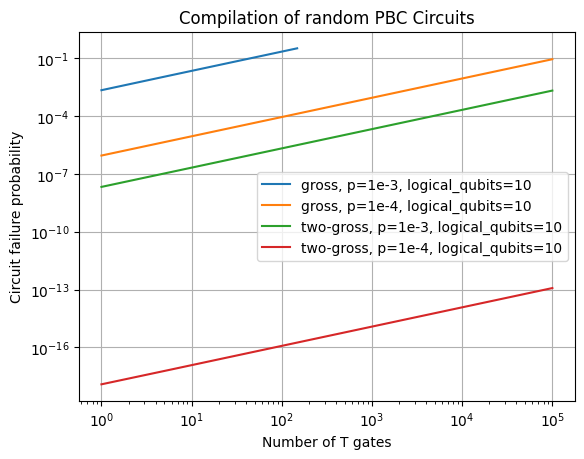

In [ ]:
for qubit_count in qubit_counts:
    for code in codes:
        for physical_noise in physical_noises:
            label = f"{code}, p={physical_noise}, logical_qubits={qubit_count}"
            noise_vs_T = mean_noises[(qubit_count, code, physical_noise)]
            plt.plot(range(1,len(noise_vs_T)+1), noise_vs_T, label=label)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of T gates")
plt.ylabel("Circuit failure probability")
plt.title("Compilation of random PBC Circuits")
plt.legend()
plt.grid()
plt.show()